In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats
from scipy.stats import pearsonr
import itertools
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
oil_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
transaction_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
stores_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
holiday_event_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')

In [3]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [5]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [6]:
transaction_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [7]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [8]:
holiday_event_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
# Sales is the target to predict

##  Merging datasets holiday_event_df, stores_df, oil_df & train_df

In [10]:
train_df = train_df.merge(stores_df, on ='store_nbr')
train_df = train_df.merge(oil_df, on ='date', how='left')
holiday_event_df = holiday_event_df.rename(columns={'type': 'holiday_type'})
train_df = train_df.merge(holiday_event_df, on='date', how='left')

In [11]:
train_df.head(3)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [13]:
train_df.to_csv('traindf_processed.csv')

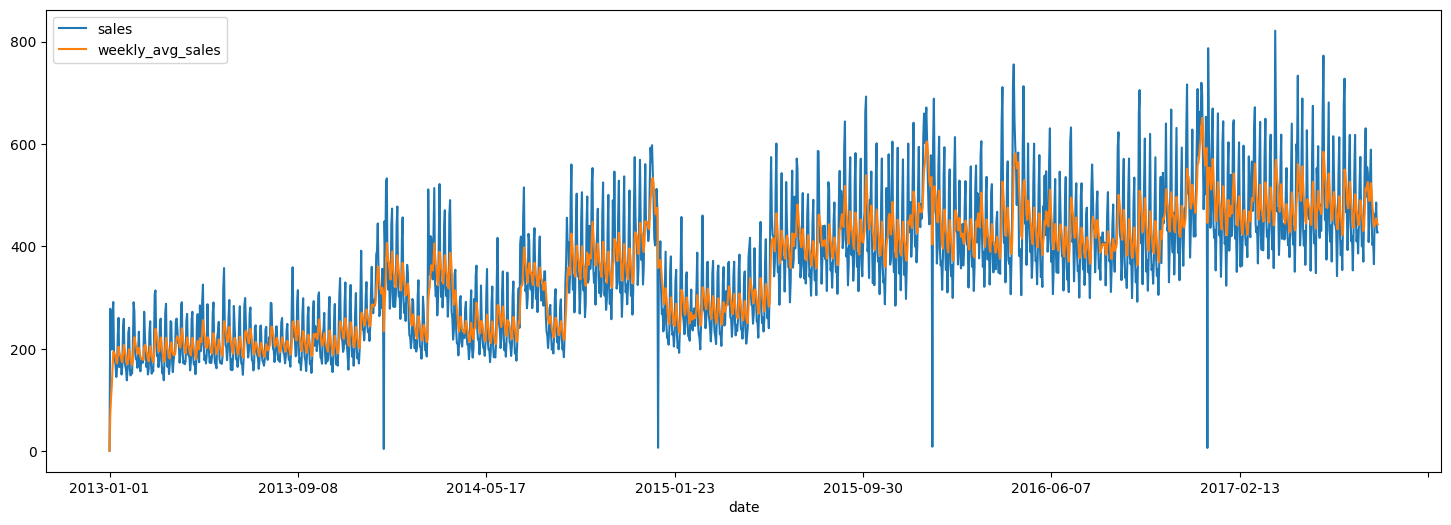

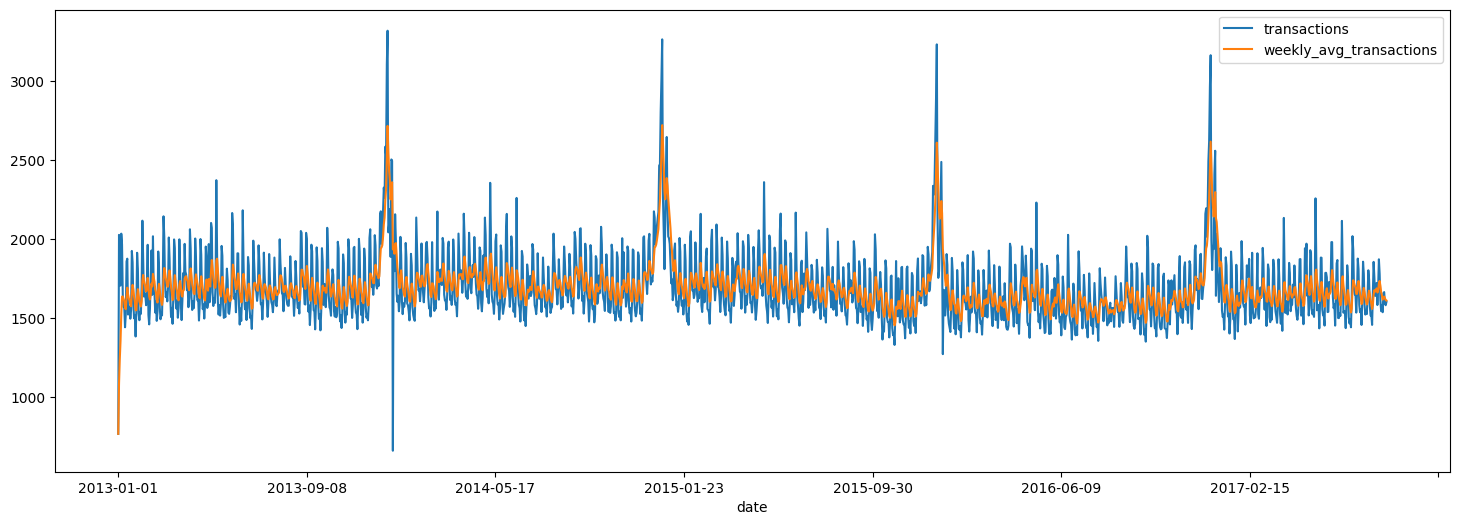

In [16]:
avg_sales = train_df.groupby('date').agg({'sales': 'mean'}).reset_index()
#daily_avg_sales['weekly_avg_sales'] = daily_avg_sales['sales'].rolling(window=7).mean()
avg_sales['weekly_avg_sales'] = avg_sales['sales'].ewm(span=7, adjust=False).mean()
#ax = daily_avg_sales.set_index('date').plot(figsize = (16, 8))
ax1 = avg_sales.plot(x= 'date', y= ['sales', 'weekly_avg_sales'], figsize=(18,6))

avg_transactions = transaction_df.groupby('date').agg({'transactions': 'mean'}).reset_index()
#avg_transaction['weekly_avg_sales'] = avg_transaction['transactions'].rolling(window=7).mean()
avg_transactions['weekly_avg_transactions'] = avg_transactions['transactions'].ewm(span=7, adjust=False).mean()

ax2 = avg_transactions.plot(x= 'date', y= ['transactions', 'weekly_avg_transactions'], figsize=(18,6))

In [18]:
transaction_df.columns

Index(['date', 'store_nbr', 'transactions'], dtype='object')

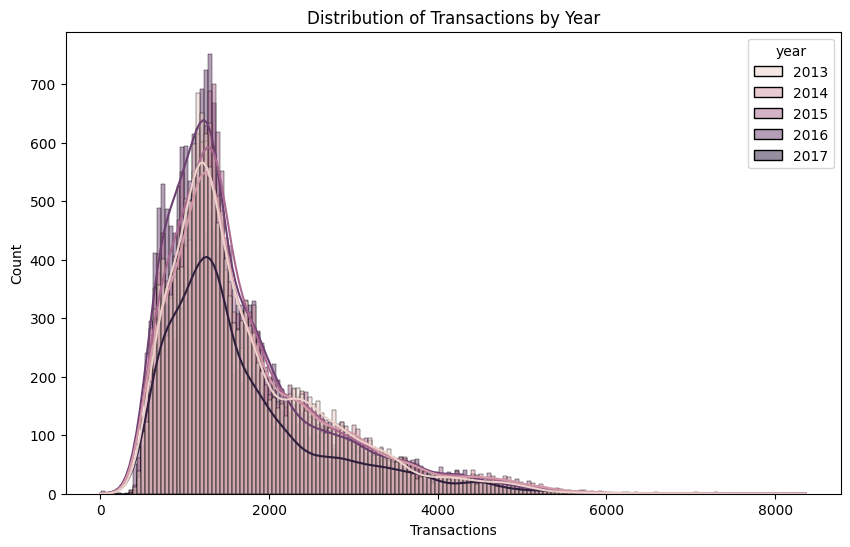

In [20]:
transaction_df['date'] = pd.to_datetime(transaction_df['date'])

# Extract the year from the 'date' column
transaction_df['year'] = transaction_df['date'].dt.year

# Plotting distribution of transactions for each year
plt.figure(figsize=(10, 6))
sns.histplot(data=transaction_df, x='transactions', hue='year', kde=True)
plt.title('Distribution of Transactions by Year')
plt.xlabel('Transactions')
plt.ylabel('Count')
plt.show()

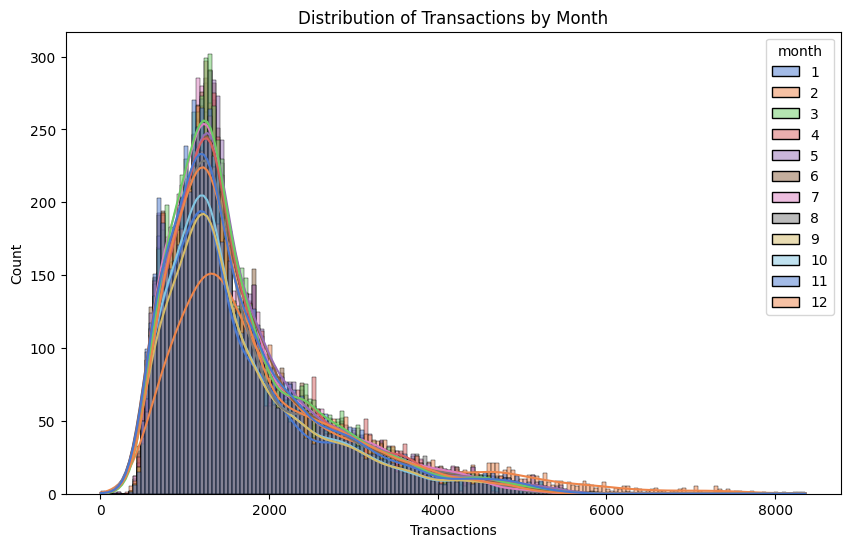

In [22]:
# Convert the 'date' column to datetime type
transaction_df['date'] = pd.to_datetime(transaction_df['date'])

# Extract the month from the 'date' column
transaction_df['month'] = transaction_df['date'].dt.month

# Plotting distribution of transactions for each month
plt.figure(figsize=(10, 6))
sns.histplot(data=transaction_df, x='transactions', hue='month', palette='muted', kde=True)
plt.title('Distribution of Transactions by Month')
plt.xlabel('Transactions')
plt.ylabel('Count')
plt.show()